In [45]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import folium
import networkx as nx
import osmnx as ox
import numpy as np
import cenpy

In [46]:
# API Key
api_key = "3sAEbbB4m1usrLLgLuNsjLVcb4fLfKLnBB4QDuee"

# requset URL
url = f"https://developer.nrel.gov/api/alt-fuel-stations/v1.json?api_key={api_key}&fuel_type=ELEC&state=CA"

# issue a request
response = requests.get(url)

# Check response status
if response.status_code == 200:
    data = response.json()
    # Save as JSON file
    with open('alt_fuel_stations.json', 'w') as f:
        json.dump(data, f, indent=4)
    print("The data is successfully downloaded and saved as alt_fuel_stations.json")
else:
    print(f"Request failed, status code: {response.status_code}, error message: {response.text}")


The data is successfully downloaded and saved as alt_fuel_stations.json


In [47]:
# request CSV data
csv_url = f"https://developer.nrel.gov/api/alt-fuel-stations/v1.csv?api_key={api_key}&fuel_type=ELEC&state=CA"
df = pd.read_csv(csv_url)

df.to_csv('alt_fuel_stations.csv', index=False)
print("The data is successfully downloaded and saved as alt_fuel_stations.csv")


/var/folders/xc/6jdw4jhn5_79w695j45v4rtr0000gn/T/ipykernel_8913/3004663735.py:3: DtypeWarning: Columns (6,20,31,46,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_url)


The data is successfully downloaded and saved as alt_fuel_stations.csv


In [33]:
base_url = "https://developer.nrel.gov/api/alt-fuel-stations/v1.json"

# Load SDG&E service territory zip codes
sdge_zipcode = pd.read_excel('SDGE Service Territory Zip Code List Q2-2021.xlsx')
zip_codes = ",".join(sdge_zipcode['ZIP_CODE'].astype(str).tolist())

# Build the request URL with filters for fuel type, state, and zip codes
url = f"{base_url}?api_key={api_key}&fuel_type=ELEC&state=CA&zip={zip_codes}"

# Request the data in JSON format
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    
    # Normalize JSON data to a DataFrame
    stations_df = pd.json_normalize(data['fuel_stations'])
    
    # Save as CSV
    stations_df.to_csv('filtered_alt_fuel_stations.csv', index=False)
    print("The filtered data is successfully saved as filtered_alt_fuel_stations.csv")
else:
    print(f"Request failed with status code {response.status_code}: {response.text}")



The number of EV chargers in the SDG&E service area is: 1162


In [54]:
# Load the CSV files
ev_file_path = 'alt_fuel_stations1.csv'
filtered_ev_file_path = 'filtered_alt_fuel_stations.csv'
sdge_file_path = 'SDGE-ELEC-2024-Q3.csv'
sdge_file_2023_q1 =  'SDGE-ELEC-2023-Q1.csv'
sdge_file_2023_q2 =  'SDGE-ELEC-2023-Q2.csv'
sdge_file_2023_q3 =  'SDGE-ELEC-2023-Q3.csv'
sdge_file_2023_q4 =  'SDGE-ELEC-2023-Q4.csv'



In [57]:
ev_chargers_df = pd.read_csv(ev_file_path)
ev_chargers_in_sdge_area = pd.read_csv(filtered_ev_file_path)
sdge_data_df = pd.read_csv(sdge_file_path)



/var/folders/xc/6jdw4jhn5_79w695j45v4rtr0000gn/T/ipykernel_8913/2798715333.py:1: DtypeWarning: Columns (6,7,19,20,24,30,31,35,36,40,46,63,69,71,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  ev_chargers_df = pd.read_csv(ev_file_path)


In [50]:
san_diego_df = ev_chargers_df[ev_chargers_df['City'] == 'San Diego']


In [51]:
num_ev_chargers_in_sd_area = san_diego_df.shape[0]

# Display the result
print(f'The number of EV chargers in the San Diego service area is: {num_ev_chargers_in_sd_area}')


The number of EV chargers in the San Diego service area is: 841


In [7]:
# Convert 'Open Date' to datetime and extract the year
ev_chargers_df['Open Date'] = pd.to_datetime(ev_chargers_df['Open Date'], errors='coerce')  # Convert to datetime, errors as NaT
ev_chargers_df['Open Year'] = ev_chargers_df['Open Date'].dt.year  # Extract the year

# Group by year to count the number of stations opened each year
stations_per_year = ev_chargers_df.groupby('Open Year').size().reset_index(name='Number of Stations Opened')

In [8]:
stations_per_year

Open Year  Number of Stations Opened
0      1995.0                          1
1      1997.0                          6
2      1998.0                         14
3      1999.0                         12
4      2000.0                          3
5      2002.0                         17
6      2004.0                         15
7      2005.0                          3
8      2006.0                          3
9      2007.0                          1
10     2008.0                         19
11     2009.0                         12
12     2010.0                         50
13     2011.0                       1070
14     2012.0                       1474
15     2013.0                        576
16     2014.0                       1140
17     2015.0                       1933
18     2016.0                       1939
19     2017.0                       2214
20     2018.0                       2953
21     2019.0                       3801
22     2020.0                       7231
23     2021.0                      16938
24     2022.0                      12044
25     2023.0                      13409
26     2024.0                       9934

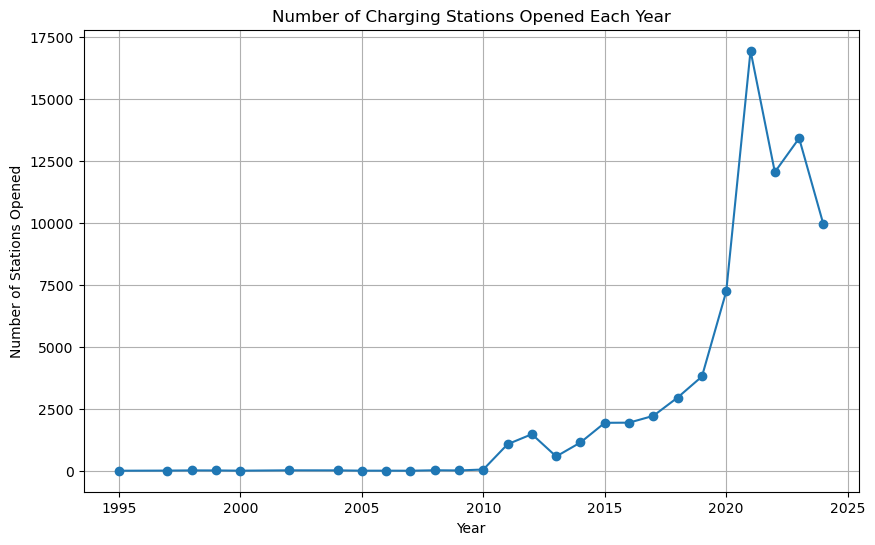

In [9]:
# Plot the time series of stations opened each year
plt.figure(figsize=(10, 6))
plt.plot(stations_per_year['Open Year'], stations_per_year['Number of Stations Opened'], marker='o')
plt.title('Number of Charging Stations Opened Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Stations Opened')
plt.grid(True)
plt.show()



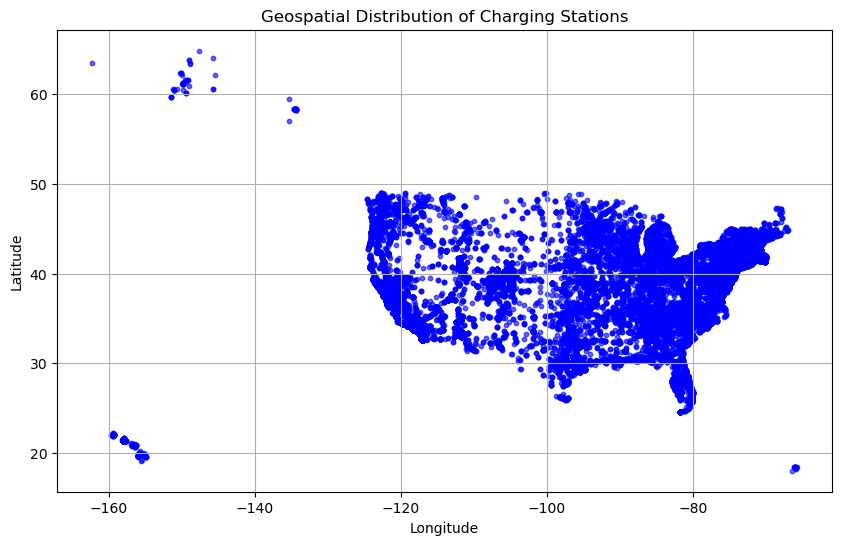

In [10]:
# Geospatial plot: using Latitude and Longitude columns
# Clean the data to remove rows with missing or non-numeric values in Latitude and Longitude

ev_chargers_df_geo_clean = ev_chargers_df.dropna(subset=['Latitude', 'Longitude']).copy()  # Make an explicit copy
ev_chargers_df_geo_clean.loc[:, 'Latitude'] = pd.to_numeric(ev_chargers_df_geo_clean['Latitude'], errors='coerce')
ev_chargers_df_geo_clean.loc[:, 'Longitude'] = pd.to_numeric(ev_chargers_df_geo_clean['Longitude'], errors='coerce')

# Simple scatter plot of geospatial data
plt.figure(figsize=(10, 6))
plt.scatter(ev_chargers_df_geo_clean['Longitude'], ev_chargers_df_geo_clean['Latitude'], c='blue', alpha=0.6, s=10)
plt.title('Geospatial Distribution of Charging Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


In [59]:
ev_chargers_in_sdge_area.columns

Index(['access_code', 'access_days_time', 'access_detail_code',
       'cards_accepted', 'date_last_confirmed', 'expected_date',
       'fuel_type_code', 'groups_with_access_code', 'id',
       'maximum_vehicle_class', 'open_date', 'owner_type_code',
       'restricted_access', 'status_code', 'funding_sources', 'facility_type',
       'station_name', 'station_phone', 'updated_at', 'geocode_status',
       'latitude', 'longitude', 'city', 'country', 'intersection_directions',
       'plus4', 'state', 'street_address', 'zip', 'bd_blends',
       'cng_dispenser_num', 'cng_fill_type_code', 'cng_has_rng', 'cng_psi',
       'cng_renewable_source', 'cng_total_compression', 'cng_total_storage',
       'cng_vehicle_class', 'e85_blender_pump', 'e85_other_ethanol_blends',
       'ev_connector_types', 'ev_dc_fast_num', 'ev_level1_evse_num',
       'ev_level2_evse_num', 'ev_network', 'ev_network_web', 'ev_other_evse',
       'ev_pricing', 'ev_renewable_source', 'ev_workplace_charging',
       'hy_i

In [20]:
ev_chargers_df['Latitude']

0        34.248319
1        34.040539
2        34.059133
3        33.759802
4        33.770508
           ...    
82601    34.017749
82602    34.019075
82603    34.019861
82604    38.733819
82605    35.956303
Name: Latitude, Length: 82606, dtype: object

In [65]:
# Re-import necessary libraries in case of environment reset

# Load the dataset again
alt_fuel_stations = ev_chargers_in_sdge_area

# Filter out rows with non-numeric Latitude and Longitude values
alt_fuel_stations_clean = alt_fuel_stations[pd.to_numeric(alt_fuel_stations['latitude'], errors='coerce').notnull() & 
                                            pd.to_numeric(alt_fuel_stations['longitude'], errors='coerce').notnull()]

# Convert Latitude and Longitude columns to numeric
alt_fuel_stations_clean['latitude'] = pd.to_numeric(alt_fuel_stations_clean['latitude'])
alt_fuel_stations_clean['longitude'] = pd.to_numeric(alt_fuel_stations_clean['longitude'])

# Create a GeoDataFrame for all EV charging stations
all_ev_stations_gdf = gpd.GeoDataFrame(
    alt_fuel_stations_clean,
    geometry=gpd.points_from_xy(alt_fuel_stations_clean.longitude, alt_fuel_stations_clean.latitude),
    crs="EPSG:4326"
)

# Plotting all EV charging stations using Folium
all_ev_map = folium.Map(location=[32.7157, -117.1611], zoom_start=10)
for _, row in all_ev_stations_gdf.iterrows():
    popup_text = f"""
    <b>Station Name:</b> {row['station_name']}<br>
    <b>Street Address:</b> {row['street_address']}<br>
    <b>City:</b> {row['city']}<br>
    <b>ZIP Code:</b> {row['zip']}<br>
    <b>Fuel Type:</b> {row['fuel_type_code']}<br>
    <b>EV Network:</b> {row['ev_network']}<br>
    """
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(all_ev_map)


# Save and display map for all EV charging stations
all_ev_map.save('all_ev_stations_map.html')
all_ev_map


In [12]:
sdge_location = (32.82434409454857, -117.1429236351)  # 示例经纬度，需根据实际位置调整
ev_charger_location = (32.831882293954735, -117.15902477363302)  # 示例经纬度，需根据实际位置调整


In [13]:
G = ox.graph_from_point(sdge_location, dist=3000, network_type='drive')  # 可以根据需要调整dist参数


/Users/zmc/anaconda3/lib/python3.11/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


In [15]:
orig_node = ox.distance.nearest_nodes(G, sdge_location[1], sdge_location[0])
dest_node = ox.distance.nearest_nodes(G, ev_charger_location[1], ev_charger_location[0])

In [16]:
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
print(f"The driving distance from SDG&E to the selected EV charger is {route_length} meters.")


The driving distance from SDG&E to the selected EV charger is 2806.5450000000005 meters.


/var/folders/xc/6jdw4jhn5_79w695j45v4rtr0000gn/T/ipykernel_10450/4119676857.py:2: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))


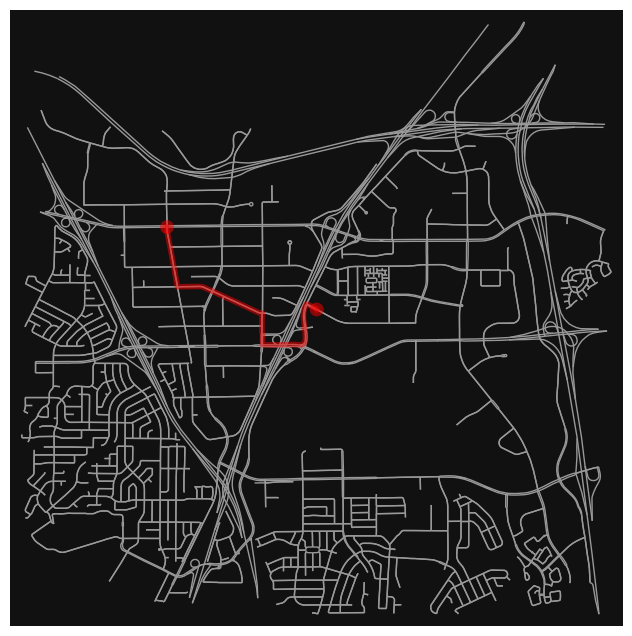

In [17]:
fig, ax = ox.plot_graph_route(G, route, node_size=0)


/var/folders/xc/6jdw4jhn5_79w695j45v4rtr0000gn/T/ipykernel_8913/635605571.py:17: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/xc/6jdw4jhn5_79w695j45v4rtr0000gn/T/ipykernel_8913/635605571.py:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/xc/6jdw4jhn5_79w695j45v4rtr0000gn/T/ipykernel_8913/635605571.py:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/xc/6jdw4jhn5_79w695j45v4rtr0000gn/T/ipykernel_8913/635605571.py:17: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/xc/6jdw4jhn5_79w695j45v4rtr0000gn/T/ipykernel_8913/635605571.py:17: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=Fa

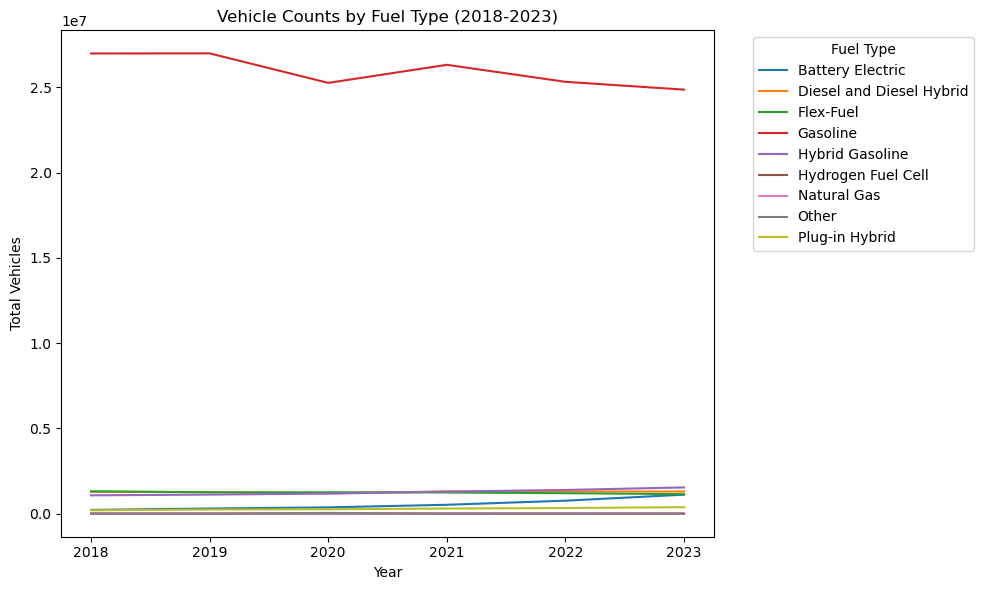

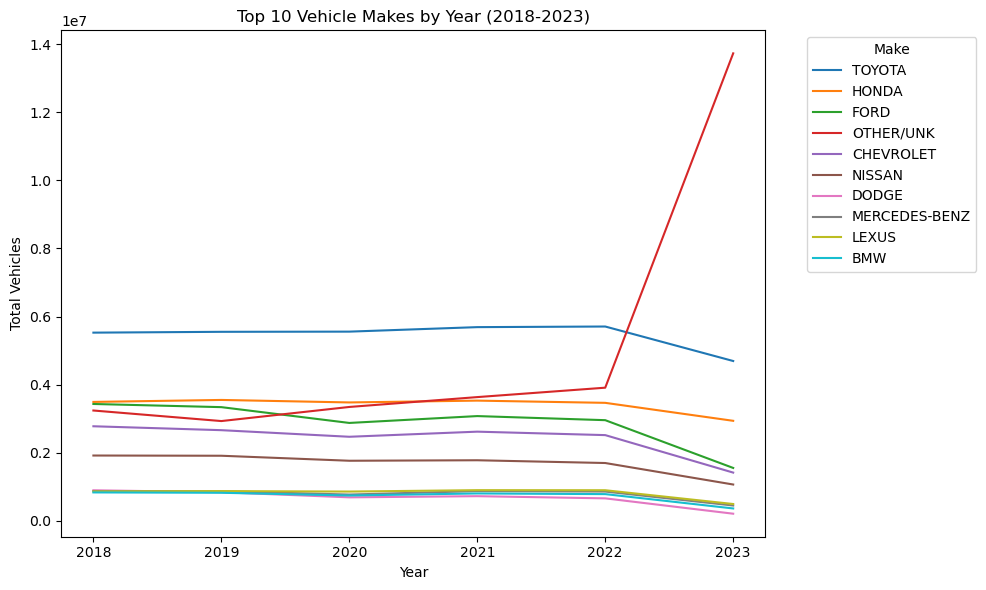

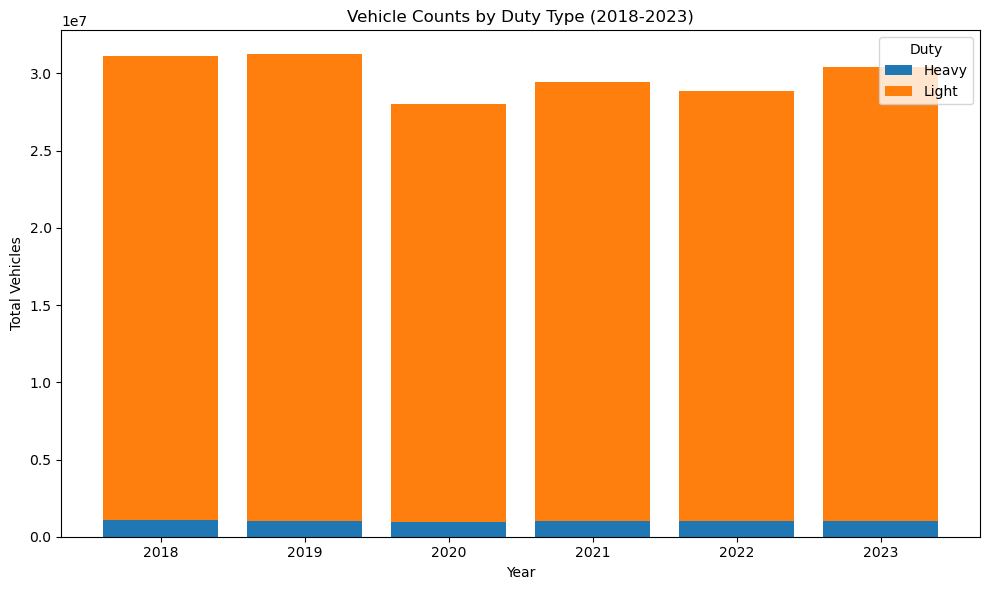

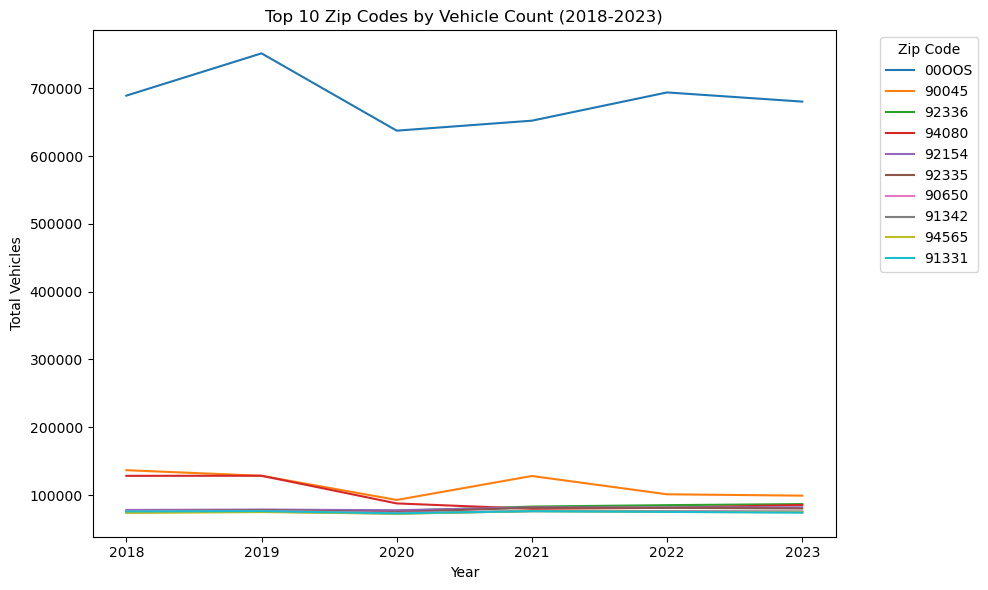

In [38]:
file_paths = {
    '2018': 'VFT_Count_Zip_2018.csv',
    '2019': 'VFT_Count_Zip_2019.csv',
    '2020': 'VFT_Count_Zip_2020.csv',
    '2021': 'VFT_Count_Zip_2021.csv',
    '2022': 'VFT_Count_Zip_2022.csv',
    '2023': 'VFT_Count_Zip_2023.csv'
}

# Load datasets into a dictionary
data_frames = {}
for year, path in file_paths.items():
    df = pd.read_csv(path)
    # Standardize column names for consistency
    df.columns = df.columns.str.replace('ZIP Code', 'Zip Code')
    df['Zip Code'] = df['Zip Code'].astype(str).str.zfill(5)  # Pad Zip Code to 5 characters
    df['Model Year'] = df['Model Year'].astype(str)           # Ensure Model Year is a string
    data_frames[year] = df

# Aggregate data for visualizations
years = list(data_frames.keys())

# 1. Vehicle Counts by Fuel Type
fuel_type_trends = {year: df.groupby('Fuel')['Vehicles'].sum() for year, df in data_frames.items()}
fuel_types = list(fuel_type_trends['2018'].index)  # Using 2018 fuel types as base
fuel_type_counts = {fuel: [fuel_type_trends[year].get(fuel, 0) for year in years] for fuel in fuel_types}

# Plot Fuel Type Trends
plt.figure(figsize=(10, 6))
for fuel, counts in fuel_type_counts.items():
    plt.plot(years, counts, label=fuel)
plt.title('Vehicle Counts by Fuel Type (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles')
plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Top 10 Vehicle Makes
make_trends = {year: df.groupby('Make')['Vehicles'].sum() for year, df in data_frames.items()}
top_makes = make_trends['2018'].nlargest(10).index  # Top 10 makes from 2018
make_counts = {make: [make_trends[year].get(make, 0) for year in years] for make in top_makes}

# Plot Vehicle Makes
plt.figure(figsize=(10, 6))
for make, counts in make_counts.items():
    plt.plot(years, counts, label=make)
plt.title('Top 10 Vehicle Makes by Year (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles')
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Duty Type Trends (Light, Heavy, Unknown)
duty_trends = {year: df.groupby('Duty')['Vehicles'].sum() for year, df in data_frames.items()}
duty_types = list(duty_trends['2018'].index)
duty_counts = {duty: [duty_trends[year].get(duty, 0) for year in years] for duty in duty_types}

# Plot Duty Type Distribution
plt.figure(figsize=(10, 6))
bottom = [0] * len(years)
for duty, counts in duty_counts.items():
    plt.bar(years, counts, bottom=bottom, label=duty)
    bottom = [sum(x) for x in zip(bottom, counts)]
plt.title('Vehicle Counts by Duty Type (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles')
plt.legend(title='Duty')
plt.tight_layout()
plt.show()

# 4. Top 10 Zip Codes by Vehicle Counts in 2023
zip_code_trends = {year: df.groupby('Zip Code')['Vehicles'].sum().sort_values(ascending=False).head(10) for year, df in data_frames.items()}
top_zip_codes = zip_code_trends['2023'].index
zip_code_counts = {zip_code: [zip_code_trends[year].get(zip_code, 0) for year in years] for zip_code in top_zip_codes}

# Plot Top Zip Codes
plt.figure(figsize=(10, 6))
for zip_code, counts in zip_code_counts.items():
    plt.plot(years, counts, label=zip_code)
plt.title('Top 10 Zip Codes by Vehicle Count (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles')
plt.legend(title='Zip Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


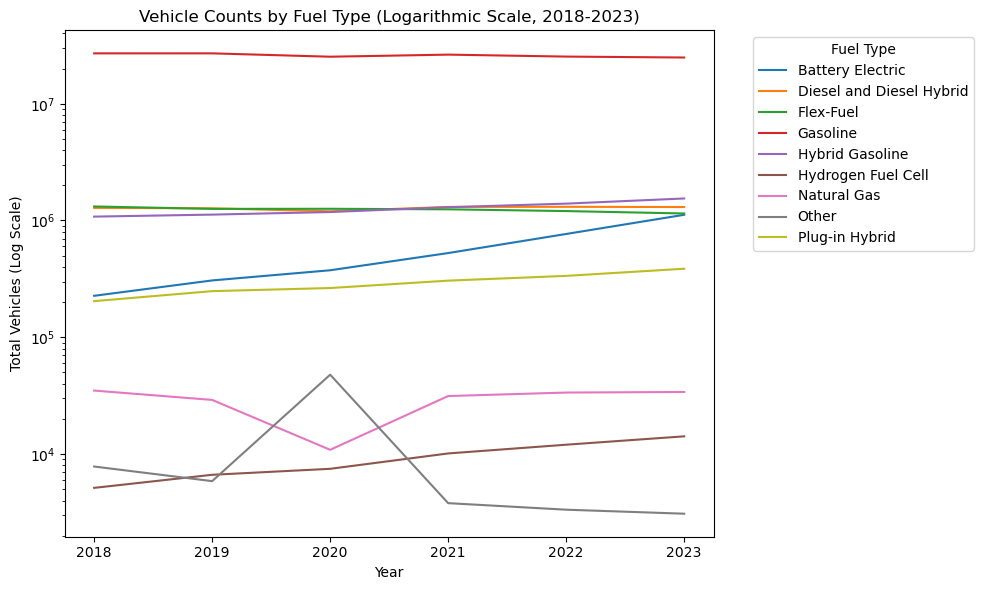

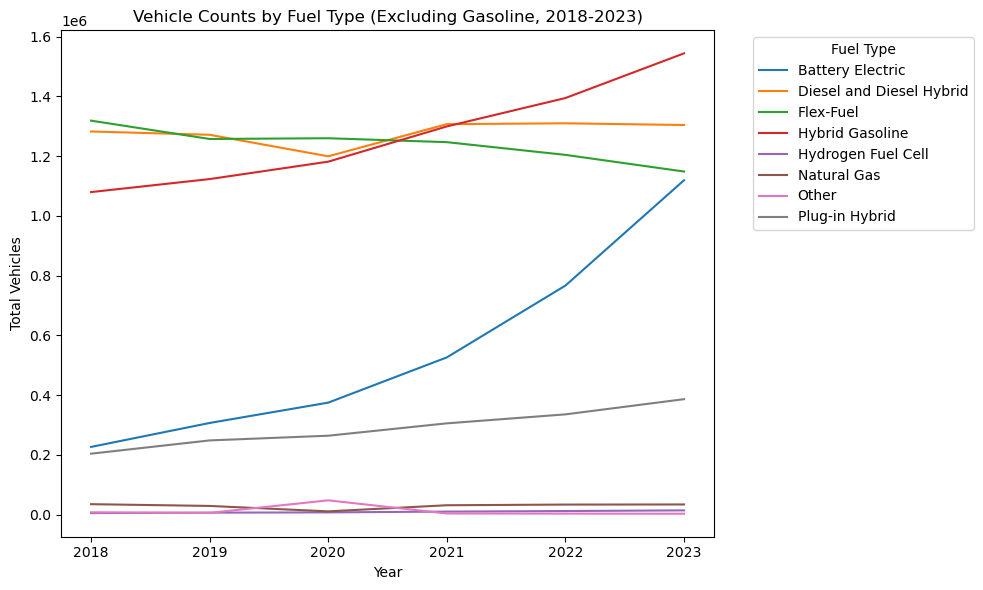

In [39]:
# Creating two visualizations for improved clarity on fuel type trends:
# 1. A plot using a logarithmic y-axis to better display all fuel types on one chart.
# 2. A plot excluding gasoline, so we can observe trends among the other fuel types.

# Logarithmic Scale Visualization
plt.figure(figsize=(10, 6))
for fuel, counts in fuel_type_counts.items():
    plt.plot(years, counts, label=fuel)
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title('Vehicle Counts by Fuel Type (Logarithmic Scale, 2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles (Log Scale)')
plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization Excluding Gasoline
plt.figure(figsize=(10, 6))
for fuel, counts in fuel_type_counts.items():
    if fuel != 'Gasoline':  # Exclude Gasoline from the plot
        plt.plot(years, counts, label=fuel)
plt.title('Vehicle Counts by Fuel Type (Excluding Gasoline, 2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles')
plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


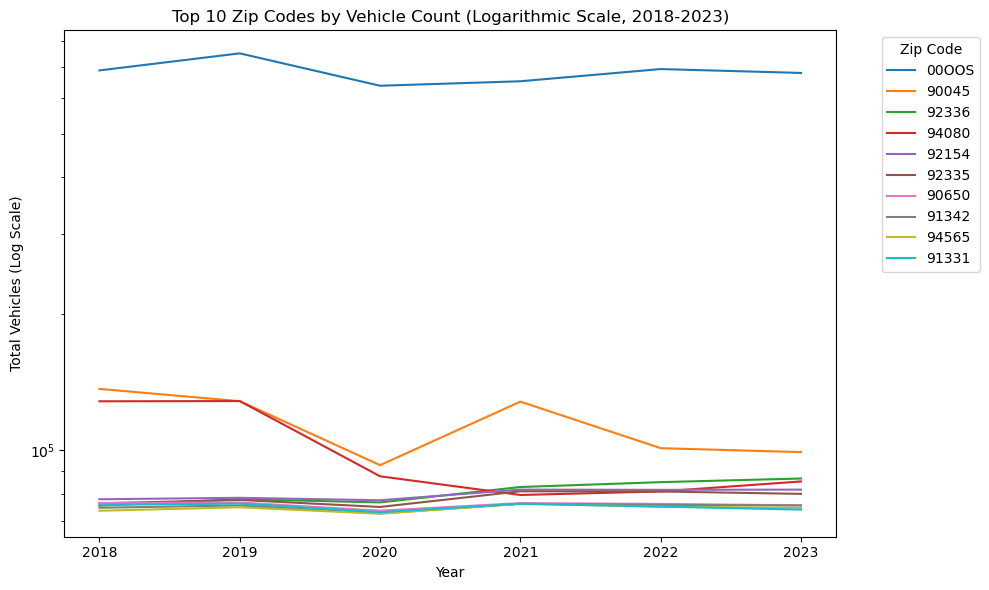

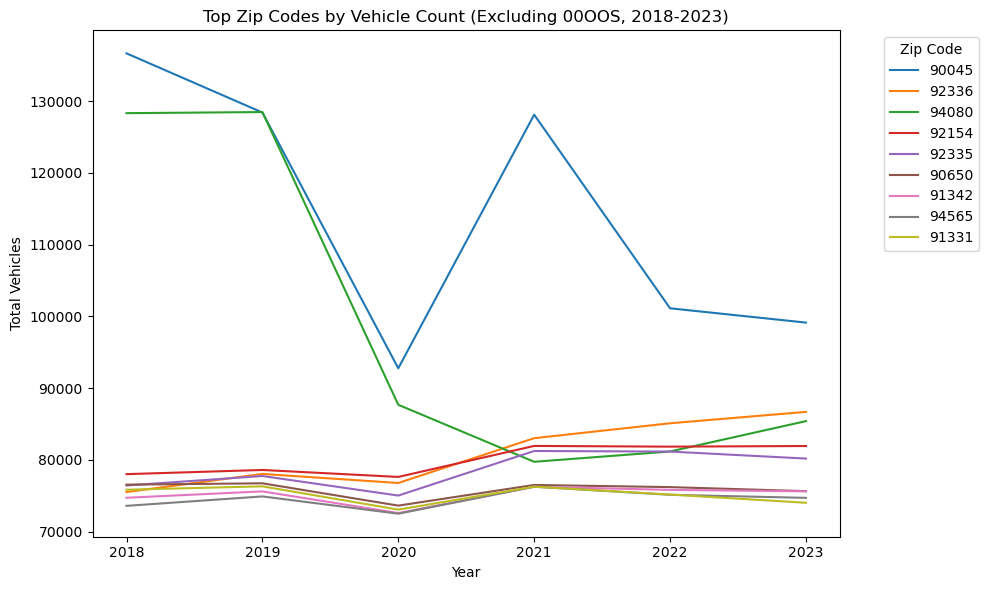

In [40]:
# Creating two visualizations for improved clarity on Zip Code trends:
# 1. A plot using a logarithmic y-axis to better display all Zip Codes on one chart.
# 2. A plot excluding the "00OOS" Zip Code, so we can observe trends among the remaining top Zip Codes.

# Logarithmic Scale Visualization
plt.figure(figsize=(10, 6))
for zip_code, counts in zip_code_counts.items():
    plt.plot(years, counts, label=zip_code)
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title('Top 10 Zip Codes by Vehicle Count (Logarithmic Scale, 2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles (Log Scale)')
plt.legend(title='Zip Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization Excluding "00OOS"
plt.figure(figsize=(10, 6))
for zip_code, counts in zip_code_counts.items():
    if zip_code != '00OOS':  # Exclude "00OOS" from the plot
        plt.plot(years, counts, label=zip_code)
plt.title('Top Zip Codes by Vehicle Count (Excluding 00OOS, 2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles')
plt.legend(title='Zip Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


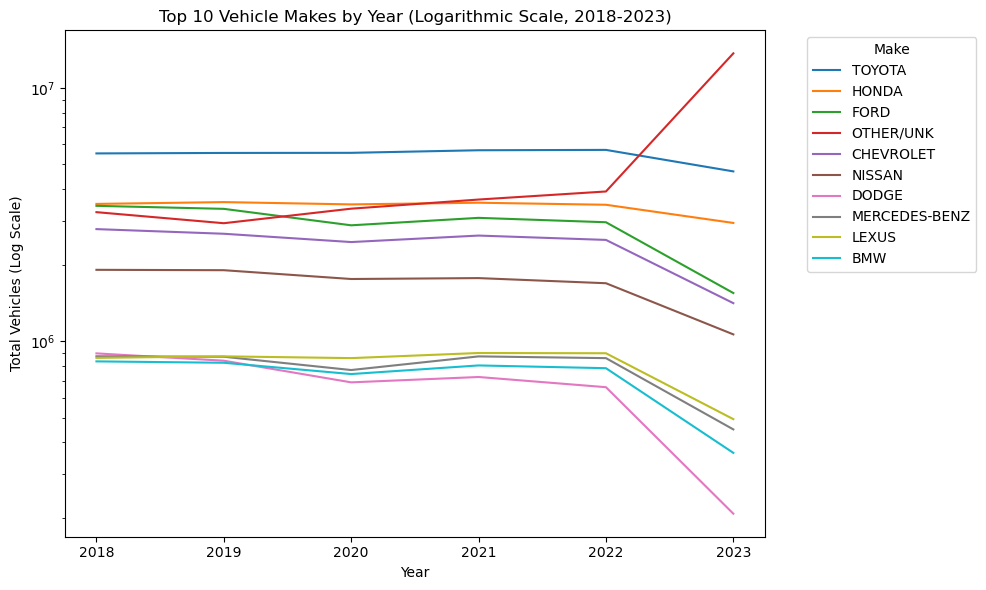

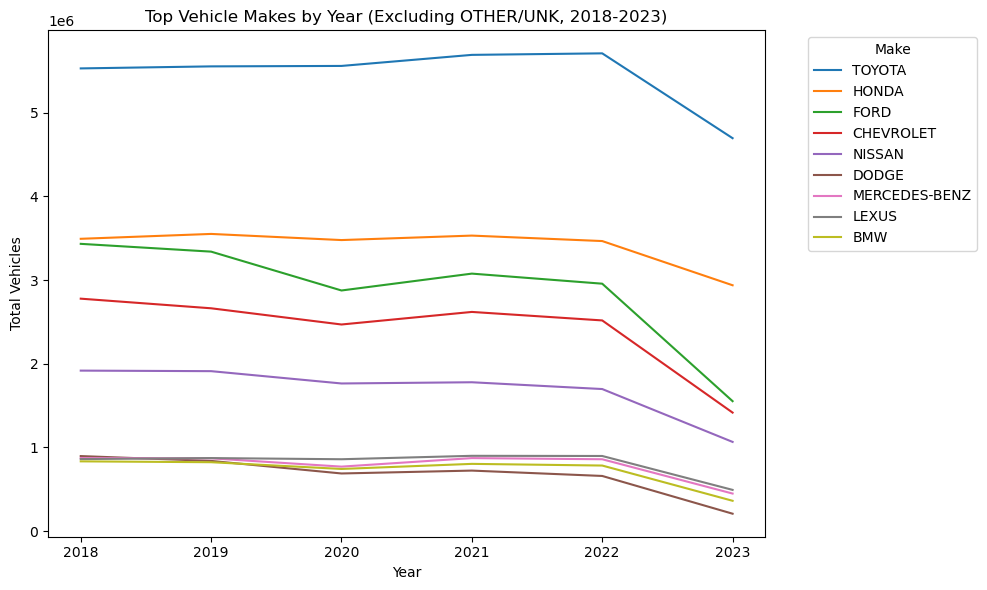

In [41]:
# 1. Logarithmic Scale Visualization
plt.figure(figsize=(10, 6))
for make, counts in make_counts.items():
    plt.plot(years, counts, label=make)
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title('Top 10 Vehicle Makes by Year (Logarithmic Scale, 2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles (Log Scale)')
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Visualization Excluding "OTHER/UNK"
plt.figure(figsize=(10, 6))
for make, counts in make_counts.items():
    if make != 'OTHER/UNK':  # Exclude "OTHER/UNK" from the plot
        plt.plot(years, counts, label=make)
plt.title('Top Vehicle Makes by Year (Excluding OTHER/UNK, 2018-2023)')
plt.xlabel('Year')
plt.ylabel('Total Vehicles')
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [53]:

# Example: Line chart with Altair for fuel types
fuel_type_df = pd.DataFrame(fuel_type_counts)
fuel_type_df['Year'] = years
fuel_type_df = fuel_type_df.melt(id_vars='Year', var_name='Fuel Type', value_name='Vehicles')

alt.Chart(fuel_type_df).mark_line().encode(
    x='Year:O',
    y=alt.Y('Vehicles:Q', scale=alt.Scale(type='log')),
    color='Fuel Type:N',
    tooltip=['Year', 'Fuel Type', 'Vehicles']
).properties(title="Altair: Fuel Type Counts by Year (Log Scale)").interactive()


alt.Chart(...)

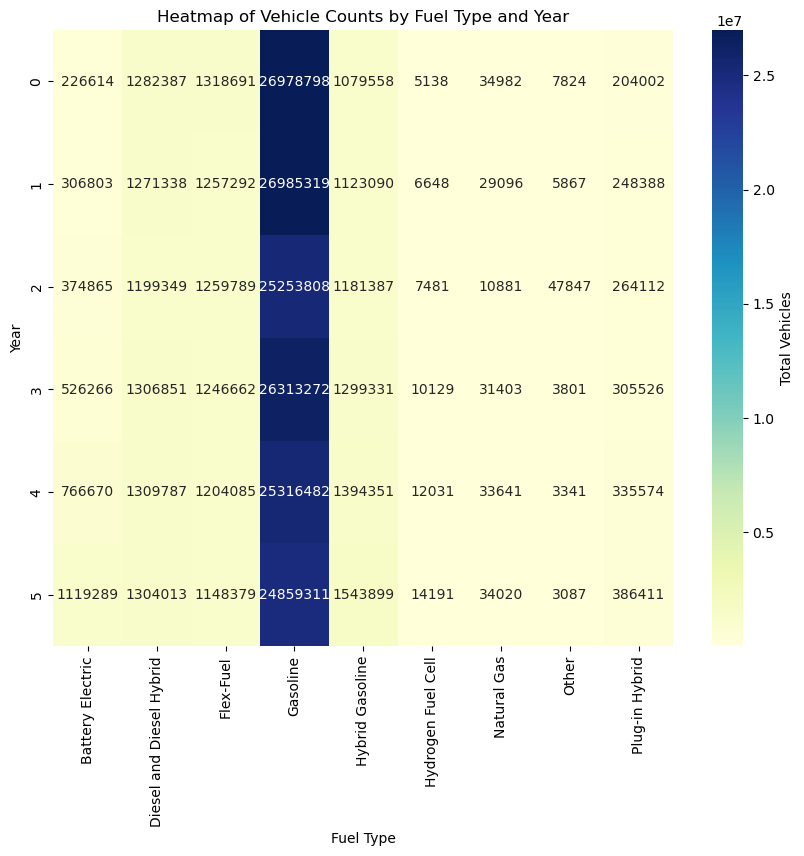

In [44]:


# Example: Heatmap for fuel types by year
fuel_type_data = pd.DataFrame(fuel_type_counts)
plt.figure(figsize=(10, 8))
sns.heatmap(fuel_type_data, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Total Vehicles'})
plt.title("Heatmap of Vehicle Counts by Fuel Type and Year")
plt.xlabel("Fuel Type")
plt.ylabel("Year")
plt.show()
